# **V6 on Complete Datatest**

In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from utils.wrapper import YOLOAPIWrappper
from utils.pipeline import CPPipeline

### **Multiplicative**

In [2]:
v6 = "../utils/v6/bestv6.onnx"
yolov6_detector = YOLOAPIWrappper(v6,file_path='../calibration/calibv6_all_test_m.pickle', conf_thres=0.7, iou_thres=0.5)
pipev6 = CPPipeline(yolov6_detector, test_set='test', method='multiplicative')

In [3]:
X_train, y_train, labels_train= pipev6.extract_yolo_dataset()
X_train, X_val, y_train, y_val, labels_train, labels_val = pipev6.calibration_and_val(X_train, y_train, labels_train)
conformal_predictor= pipev6.pipeline( X_train=X_train, y_train= y_train, labels_train= labels_train)

Predictions: [[1228.67211914 1400.33520508 1279.97216797 1464.41381836]
 [1447.62341309 1057.62963867 1640.74133301 1131.70825195]
 [1529.84985352 1209.61474609 1707.33520508 1396.5847168 ]
 ...
 [ 871.67877197 1024.9050293   939.8135376  1067.05859375]
 [1466.71081543 1103.89147949 1593.82556152 1250.55822754]
 [1266.87561035 1106.28674316 1389.25109863 1198.15393066]]
Matched Ground Truths: [[1229. 1398. 1278. 1467.]
 [1443. 1056. 1638. 1132.]
 [1529. 1209. 1709. 1404.]
 ...
 [ 871. 1021.  942. 1069.]
 [1464. 1104. 1591. 1246.]
 [1271. 1106. 1379. 1198.]]
Images: ['/home/aws_install/data/yolo_database/images/test/OMAD_13_35_03.jpeg', '/home/aws_install/data/yolo_database/images/test/mg7v0EMfJ74_ZBAA47.png', '/home/aws_install/data/yolo_database/images/test/UbPJcYKDwpM_LSZH49.png', '/home/aws_install/data/yolo_database/images/test/LICJ_20_35_05.jpeg', '/home/aws_install/data/yolo_database/images/test/LICJ_25_35_11.jpeg', '/home/aws_install/data/yolo_database/images/test/SAEZ_17_35_22.

Predictions: (array([[2382.2827,  659.1892, 2651.6484,  867.499 ]], dtype=float32), array([0.960034], dtype=float32))
Marginal coverage: 1.0
Average area: 68605.3984375
Confidence score : [0.960034]


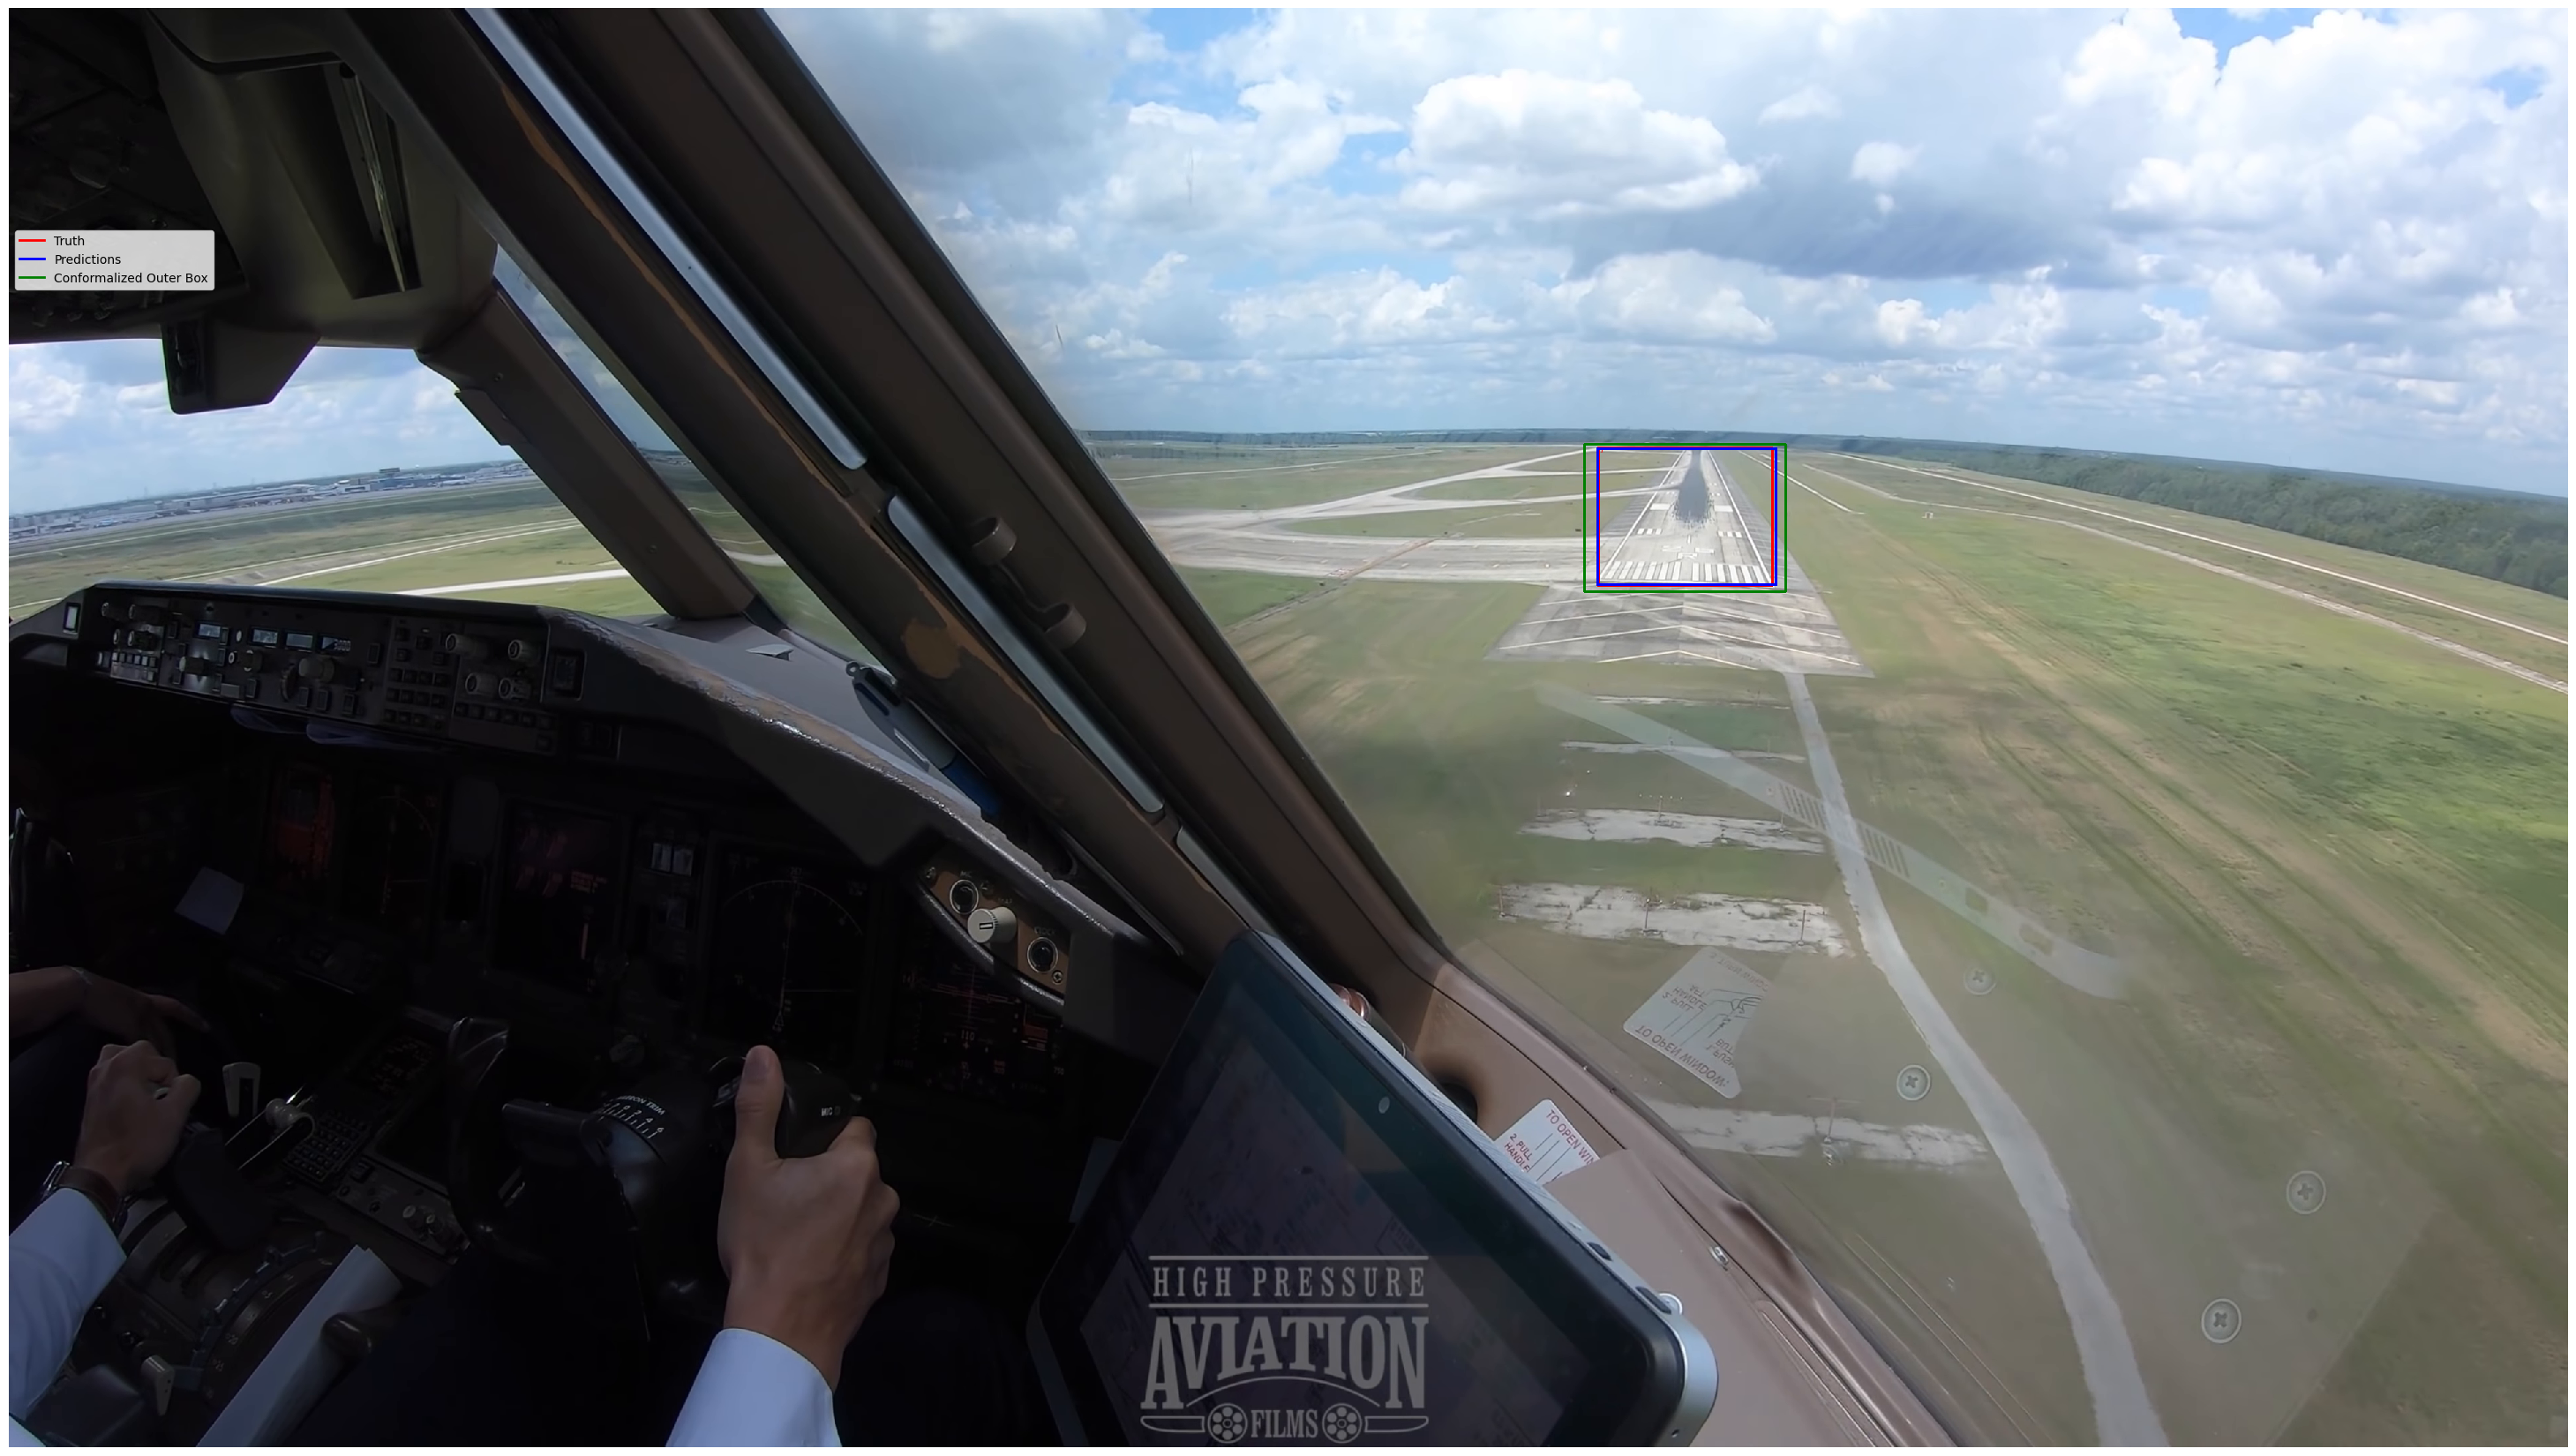

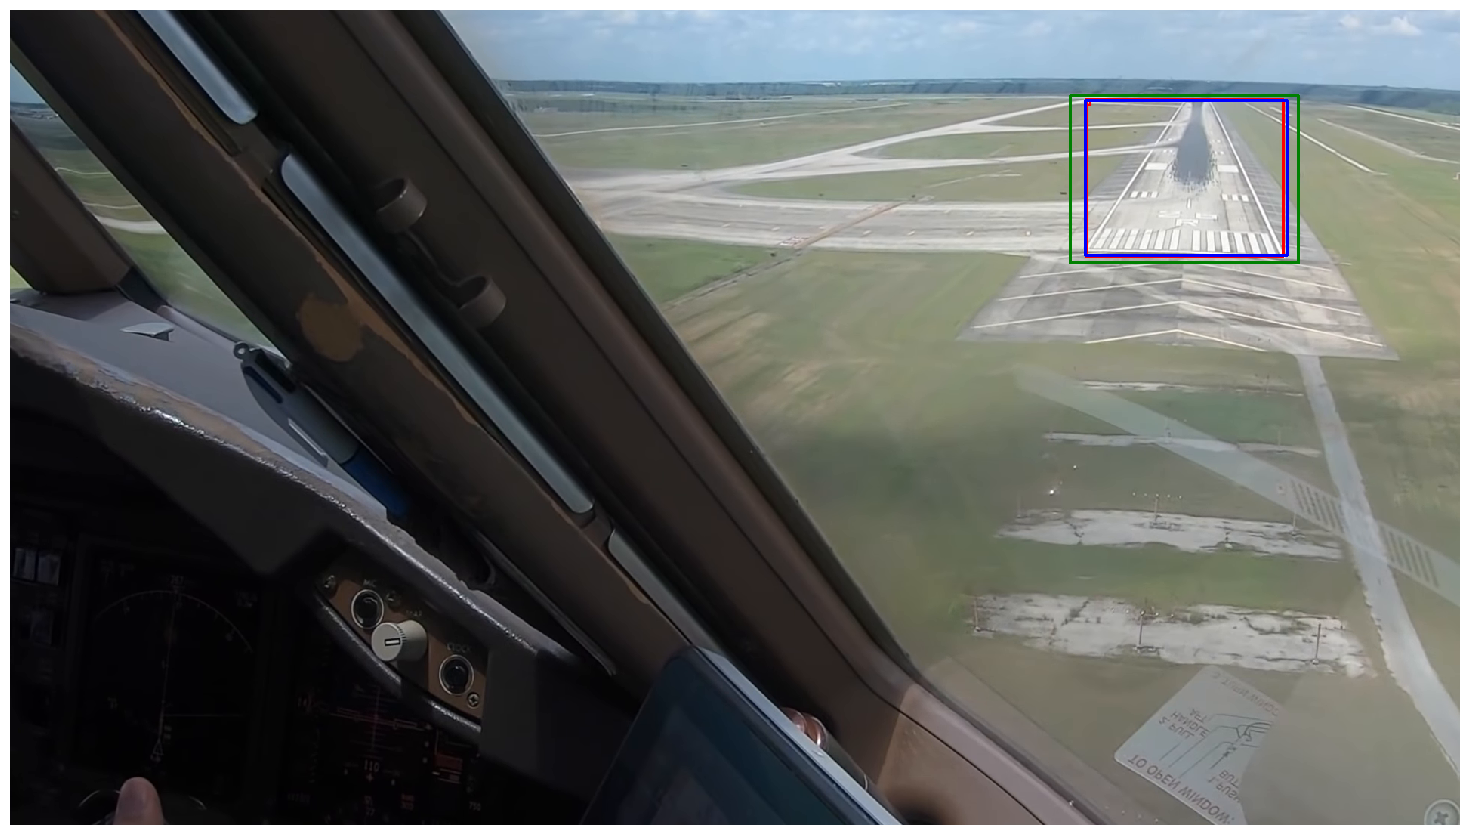

In [7]:
pipev6.infer_eval_single_image(
    conformal_predictor, 
    X_val[148],  # Image path at index 5
    y_val[148],  # Ground truth bounding boxes at index 5
    labels_val[148],  # Labels at index 5
    None  
)

In [4]:
y_pred_val, y_true_val, images_val, classes_val,score_val, box_inner_val, box_outer_val = pipev6.infer_all_images(conformal_predictor,X_val, y_val, labels_val, visualize = False)

Number of images: 463
Number of images without predictions: 18
Number of images with predictions: 445


In [5]:
average_glo_area, cover = pipev6.average_cover_and_area(y_pred_val, y_true_val, box_outer_val)

Average area of prediction intervals: 67361.1796875
Average length of prediction intervals: 259.5403137207031
Average Marginal coverage: 0.7393258426966293


In [6]:
import os
import pandas as pd
from utils.helpers import iou, ioa

filenames = []
all_preds = []
all_trues = []
all_classes = []
iou_pred_c_gt = []
ioa_pred_c_gt = []
iou_pred_gt = []
ioa_pred_gt = []
score = []
box_inner = []
box_outer = []
all_cover = []
glo_area = []


for y_pred_, y_true_, img_path_, clss_, score_, box_inner_, box_outer_, cover_, avg_area_ in zip(y_pred_val, y_true_val, X_val, classes_val, score_val, box_inner_val, box_outer_val, cover, average_glo_area):


    filenames.append(os.path.basename(img_path_))
    all_preds.append(y_pred_)
    all_trues.append(y_true_)
    all_classes.append(clss_)
    iou_pred_c_gt.append(iou(box_outer_.flatten(), y_true_.flatten())) # iou between outer box and gt
    ioa_pred_c_gt.append(ioa(box_outer_.flatten(), y_true_.flatten())) # ioa between outer box and gt
    iou_pred_gt.append(iou(y_pred_.flatten(), y_true_.flatten()))   # iou between yolo pred and gt
    ioa_pred_gt.append(ioa(y_pred_.flatten(), y_true_.flatten()))  # ioa between yolo pred and gt
    score.append(score_) # confidence score
    box_inner.append(box_inner_)
    box_outer.append(box_outer_)
    all_cover.append(cover_) #cover between conformal box and gt
    glo_area.append(avg_area_)

df = pd.DataFrame({
    'filename': filenames,
    'pred_yolo': all_preds,
    'gt': all_trues,
    'class': all_classes,
    'iou_pred_c_gt': iou_pred_c_gt,
    'ioa_pred_c_gt': ioa_pred_c_gt,
    'iou_pred_gt': iou_pred_gt,
    'ioa_pred_gt': ioa_pred_gt,
    'score': score,
    'box_inner': box_inner,
    'box_outer': box_outer,
    'cover': cover,
    'avg_area': glo_area
})

all = pd.read_csv("/home/aws_install/conformal_runway_detection/surrogate/all_test_with_real.csv")

all_subset = all[['filename', 'slant_distance', 'time_to_landing']]

df = pd.merge(df, all_subset, on='filename', how='outer')

df.to_csv('results_v6_m.csv', index=False)